## Final Model Results - Prediction of LSOA income estimates

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import numpy as np

I am going to do both the training and predictions in the same file for simplicity. 

In [13]:

# These are file paths needed for training and predictions
data_path = '../../data/processed/lsoa_census_standardized.csv'
model_path = '../../model/knn_model.pkl'
scaler_path = '../../model/scaler.pkl'
predictions_path = '../../data/processed/lsoa_income_predictions.csv'

# Loading the preprocessed dataset
data = pd.read_csv(data_path)

# Preparing the data
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
X = data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])  # Features
y = data['net_income_after_housing_costs_()']  # Target variable

# Splitting data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the model
knn = KNeighborsRegressor(n_neighbors=5)  # You can optimize this parameter
knn.fit(X_train_scaled, y_train)

# Saving the model and scaler for reuse
joblib.dump(knn, model_path)
joblib.dump(scaler, scaler_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

# Step 4: Evaluating the Model
y_pred = knn.predict(X_test_scaled)

# Computing the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Evaluation Metrics:\nMAE: {mae}\nRMSE: {rmse}\nR²: {r2}")

# Making Predictions on LSOA Data
# Load LSOA data (assume it's already standardized and the same as `data_path`)
lsoa_data = pd.read_csv(data_path)

# Selecting only features for prediction
lsoa_data_features = lsoa_data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])

# Scaling the LSOA features using the fitted scaler
lsoa_data_features_scaled = scaler.transform(lsoa_data_features)

# Predicting the income estimates
lsoa_income_predictions = knn.predict(lsoa_data_features_scaled)

# Add predictions to the LSOA dataset
lsoa_data['predicted_income'] = lsoa_income_predictions

# Save predictions to a CSV file
lsoa_data.to_csv(predictions_path, index = False)
print(f"LSOA income predictions saved to {predictions_path}")


Model saved to ../../model/knn_model.pkl
Scaler saved to ../../model/scaler.pkl
Evaluation Metrics:
MAE: 0.24826180775382545
RMSE: 0.32966203674803696
R²: 0.8933044689770794


C:\Users\bretu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LSOA income predictions saved to ../../data/processed/lsoa_income_predictions.csv


Due to time constraints, I do not have time to analyse and scrutinise the results. If there was time, I would have used the MSOA-level totals as a baseline for the validation of LSOA net income estimates. I will do a simple visulisation to get an overview of the statistics to see if there are imbalances or outliers (obvious ones of course!). It would have been nice to apply these predictions on the map, but that is why I made a scaler path for future use.

Summary Statistics for Predicted Income:
count    4762.000000
mean       -0.008322
std         0.915489
min        -1.631439
25%        -0.757869
50%        -0.129511
75%         0.590801
max         2.613806
Name: predicted_income, dtype: float64


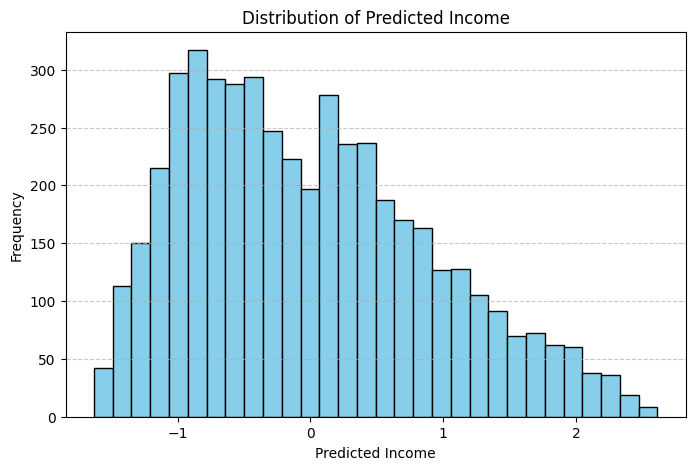

In [19]:
# A quick overview and statistical summary
summary = lsoa_data['predicted_income'].describe()
print("Summary Statistics for Predicted Income:")
print(summary)

# Histogram of predicted incomes
plt.figure(figsize=(8, 5))
plt.hist(lsoa_data['predicted_income'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Income")
plt.xlabel("Predicted Income")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

And yes the figures are still standardised, where 0 is the mean and the values above are the standard deviations. The standard deviation is 0.915 which falls under one standard deviation. There seems to be bimodal nature towards where the mean value is, indicating that there may be two distinct groups, I'm assuming that this could be the gap between the wealthy and the least wealthy.

In [18]:
# Display the head of the ID column and the new predictions column
id_column = lsoa_data.columns[0]  # Assuming the first column acts as an ID
print(lsoa_data[[id_column, 'predicted_income']].head())

   lsoa_code  predicted_income
0  E01000027         -1.018408
1  E01000028         -0.972430
2  E01000029         -0.328747
3  E01000030         -0.803846
4  E01000031         -0.420701


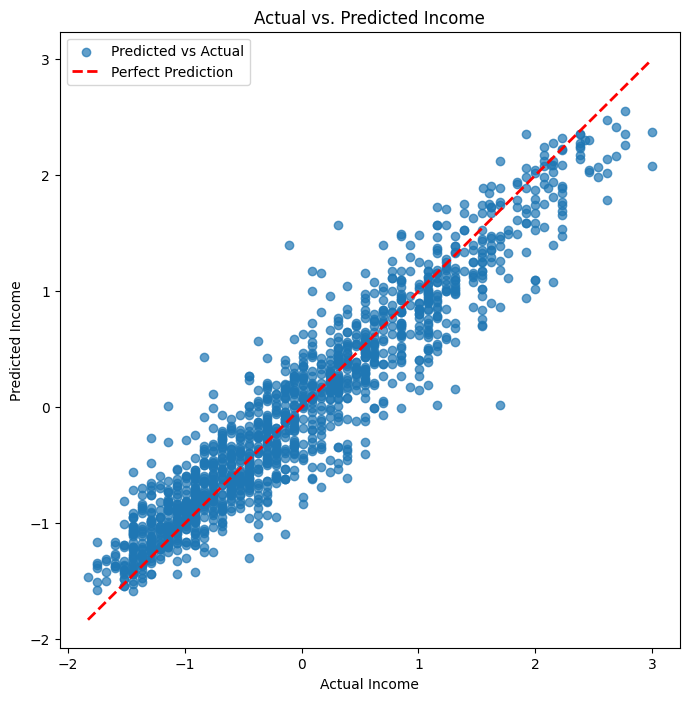

In [16]:
# Scatter plot of actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Income")
plt.ylabel("Predicted Income")
plt.title("Actual vs. Predicted Income")
plt.legend()
plt.show()

This is the same scatter plot for the training and evaluation of the chosen model.